<a href="https://colab.research.google.com/github/bye23mj/suanLee/blob/main/TF_10_2_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_CIFAR10_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치 CIFAR10 모델
- 코드 출처: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## modules import

In [ ]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

- 현재 GPU 설정

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

#with strategy.scope():

## 전처리 설정

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## 데이터 로드 및 확인

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/content/',
                                      train=True,
                                      download=True,
                                      transform=transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                      train=False,
                                      download=True,
                                      transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset, 
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                         batch_size=4,
                         shuffle=False,
                         num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

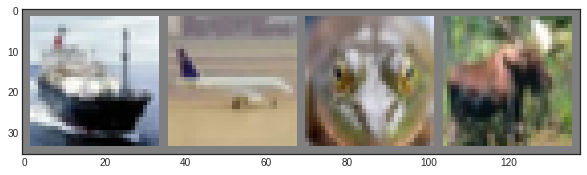

ship	plane	frog	deer	


In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))  

print(''.join('{}\t'.format(classes[labels[j]]) for j in range(4)))

## 신경망 구성

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

with strategy.scope():
  net = Net()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 손실함수와 옵티마이저

In [ ]:
cirterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

- 설명을 위해 `epochs=2`로 지정

In [ ]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = cirterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print("Epoch: {}, Iter:{}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0  

Epoch: 1, Iter:2000, Loss: 2.1960512402653696
Epoch: 1, Iter:4000, Loss: 1.9405354833900927
Epoch: 1, Iter:6000, Loss: 1.701378418534994
Epoch: 1, Iter:8000, Loss: 1.6072524860948325
Epoch: 1, Iter:10000, Loss: 1.5220496766269207
Epoch: 1, Iter:12000, Loss: 1.4803206968009472
Epoch: 2, Iter:2000, Loss: 1.4254628590792418
Epoch: 2, Iter:4000, Loss: 1.3816821574270726
Epoch: 2, Iter:6000, Loss: 1.3713195874020456
Epoch: 2, Iter:8000, Loss: 1.3356628827378154
Epoch: 2, Iter:10000, Loss: 1.32426029246673
Epoch: 2, Iter:12000, Loss: 1.3127258868291973


## 모델의 저장 및 로드

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

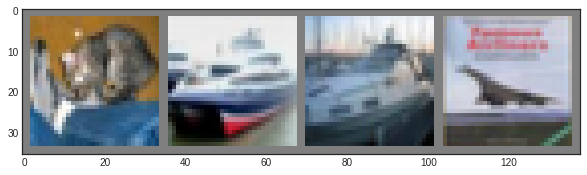

cat	ship	ship	plane	


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('{}\t'.format(classes[labels[j]]) for j in range(4)))

In [ ]:
with strategy.scope():
  net = Net()
  #net = Net().to(device)
  net.load_state_dict(torch.load(PATH))

## 모델 테스트

In [ ]:
#outputs = net(images.to(device))
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 0, 1, 0])


In [ ]:
correct = 0
total = 0

print

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    output = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    #print(images.size(), labels.size()) 16
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

10.05


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
class_corrent = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:  
    images, labels = data
    output = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_corrent[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print("Accuracy of {}: {}%".format(classes[i], 100 * class_corrent[i] / class_total[i]))

Accuracy of plane: 50.2%
Accuracy of car: 26.0%
Accuracy of bird: 0.0%
Accuracy of cat: 24.3%
Accuracy of deer: 0.0%
Accuracy of dog: 0.0%
Accuracy of frog: 0.0%
Accuracy of horse: 0.0%
Accuracy of ship: 0.0%
Accuracy of truck: 0.0%
